# Transfer Learning
_Transfer learning is a machine learning technique where a model developed for a specific task is reused as the starting point for a new, related task_

## model that we will use is VGG-16

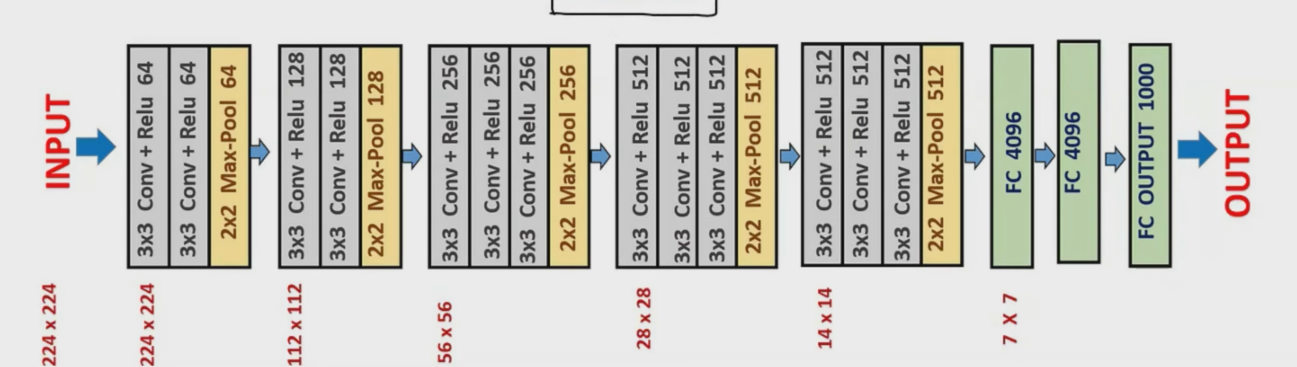

## Loading a prerequisites

In [10]:
import pandas as pd 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [11]:
#  set random seed for reproducibility
torch.manual_seed(42)

In [12]:
# check for gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device {device}")

using device cuda


## Loading Data

In [13]:
df = pd.read_csv("fmnist/fashion-mnist_train.csv")
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
df.shape

(60000, 785)

## Visualizing The Dataset

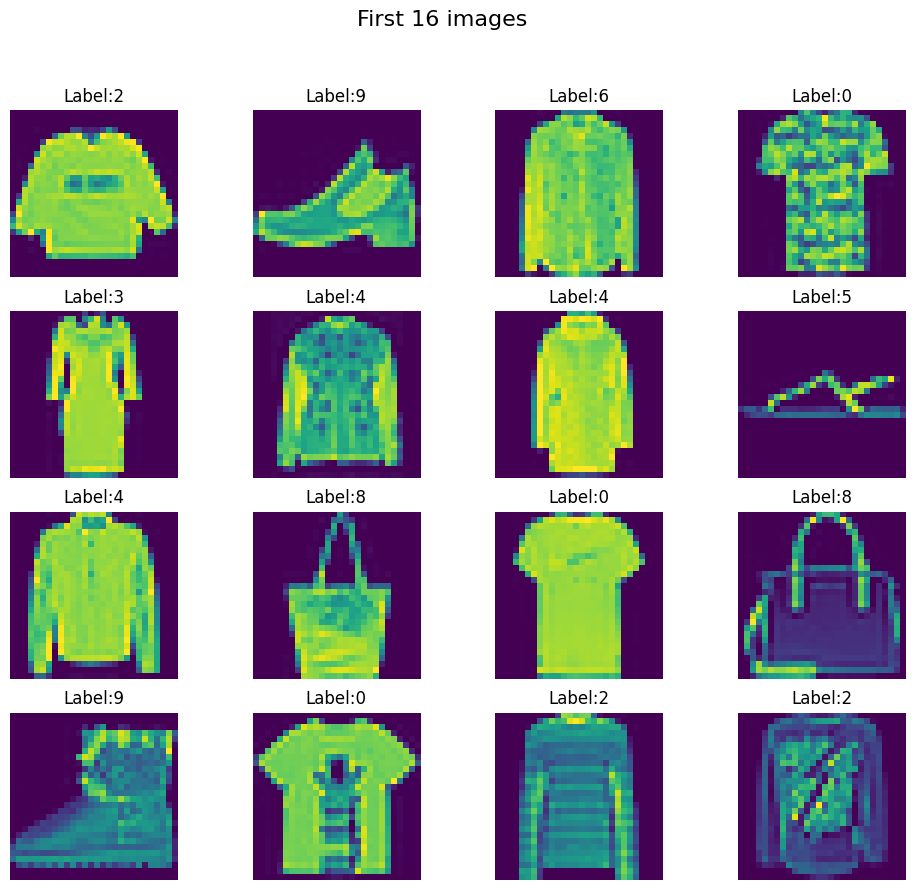

In [15]:
# create a 4x4 grid
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(12,10))
fig.suptitle("First 16 images", fontsize=16)

# ploting
for i,ax in enumerate(ax.flat):
    img = df.iloc[i,1:].values.reshape(28,28)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(f"Label:{df.iloc[i,0]}")

plt.show()

## Spliting DataSet

In [16]:
x = df.iloc[:,1:].values
y = df.iloc[:,0].values

xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.4,random_state=42)

print(f"xtrain shape:{xtrain.shape}")
print(f"xtest shape:{xtest.shape}")
print(f"ytrain shape:{ytrain.shape}")
print(f"ytest shape:{ytest.shape}")

xtrain shape:(36000, 784)
xtest shape:(24000, 784)
ytrain shape:(36000,)
ytest shape:(24000,)


## Data Transformations
_We have to perform some data transformations as per the requirements of vgg16_

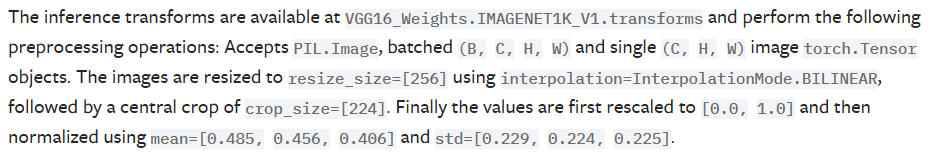

In [17]:
from torchvision.transforms import transforms

custom_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [35]:
from PIL import Image
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, features, labels, transform):
        self.features = features
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.features)

    def __getitem__(self,index):

        # resize to (28,28)
        image = self.features[index].reshape(28,28)

        # change datatype to np.uint8
        image = image.astype(np.uint8)

        # change black&white to color
        image = np.stack([image]*3,axis=-1) #axis -1 convert (C H W) to (H W C)

        # convert array to PIL Image (format->height,weight,channel)
        image =Image.fromarray(image)

        # apply transforms
        image = self.transform(image)

        # return
        return image, torch.tensor(self.labels[index], dtype = torch.long)

In [36]:
# creating train and test dataset object
train_dataset = CustomDataset(xtrain, ytrain,transform=custom_transform)
test_dataset = CustomDataset(xtest, ytest,transform=custom_transform)

In [37]:
# Creating train test loader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,pin_memory=True)

# Load a pre-trained model

In [23]:
import torchvision.models as models

vgg16 = models.vgg16(pretrained=True)

D:\machine learning\Artificial intelligence\PyTorch\torchenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\machine learning\Artificial intelligence\PyTorch\torchenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\updes/.cache\torch\hub\checkpoints\vgg16-397923af.pth


100%|███████████████████████████████████████████████████████████████████████████████| 528M/528M [01:56<00:00, 4.75MB/s]


In [25]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Freeze layers (optional but common)

In [26]:
for param in vgg16.features.parameters():
    param.requires_grad = False

# Modify the architecture

In [27]:
vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [29]:
vgg16.classifier = nn.Sequential(
    nn.Linear(25088,1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024,512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512,10),
)

In [30]:
vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=1024, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=1024, out_features=512, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=512, out_features=10, bias=True)
)

# Define Learning_rate, epoch, optimizer, loss function and model

In [31]:
Learning_rate = 0.001
epochs = 10

In [33]:
model = vgg16
# model = model.to(device)
Lossfunction = nn.CrossEntropyLoss()
optimzer = optim.Adam(model.classifier.parameters(), lr = Learning_rate)

# Train the model

In [38]:
for epoch in range(epochs):
    total_epoch_loss = 0
    for batch_features, batch_label in train_loader:
        
        # forword pass
        outputs = model(batch_features)
        
        # calcluate loss
        loss = Lossfunction(outputs, batch_label)
        
        # back prop
        optimzer.zero_grad()
        loss.backward()
        
        # upgrade grads
        optimzer.step()

        total_epoch_loss = total_epoch_loss + loss.item()
    # priniting the avrage loss per epoch
    avg_loss = total_epoch_loss/len(train_loader)
    print(f"Epoch: {epoch+1} , Loss: {avg_loss} , total_epoch_loss:{total_epoch_loss}" )

KeyboardInterrupt: 

# Evaluate